### Import libraries

In [1]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd

### Global variables

In [2]:
article_id = 14096681
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
raw_data_directory = "../data/raw/"
unzip_directory = "../data/unzip"
combined_directory = "../data/combined"
files_to_dl = ["data.zip"]
dtypes = {
    "lat_min": "float16",
    "lat_max": "float16",
    "lon_min": "float16",
    "lon_max": "float16",
    "rain (mm/day)": "float16",
    "model": "str",
}

### Check files from API

In [3]:
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)
files = data["files"]
files

[{'id': 26579150,
  'name': 'daily_rainfall_2014.png',
  'size': 58863,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579150',
  'supplied_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'computed_md5': 'fd32a2ffde300a31f8d63b1825d47e5e'},
 {'id': 26579171,
  'name': 'environment.yml',
  'size': 192,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579171',
  'supplied_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'computed_md5': '060b2020017eed93a1ee7dd8c65b2f34'},
 {'id': 26586554,
  'name': 'README.md',
  'size': 5422,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26586554',
  'supplied_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'computed_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c'},
 {'id': 26766812,
  'name': 'data.zip',
  'size': 814041183,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26766812',
  'supplied_md5': 'b517383f76e77bd03755a63a8f

### 3.1 Download file

In [4]:
%%time
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(raw_data_directory, exist_ok=True)
        urlretrieve(file["download_url"], raw_data_directory + file["name"])

CPU times: user 6.53 s, sys: 6.52 s, total: 13 s
Wall time: 2min 8s


### 3.2 Unzip the file

In [5]:
%%time
os.makedirs(unzip_directory, exist_ok=True)
with zipfile.ZipFile(os.path.join(raw_data_directory, "data.zip"), 'r') as f:
    f.extractall(unzip_directory)

CPU times: user 14.4 s, sys: 807 ms, total: 15.3 s
Wall time: 16 s


### 4.0 Remove unnecessary csv

In [6]:
os.remove(unzip_directory + "/observed_daily_rainfall_SYD.csv")

### 4.1 Merge files

In [7]:
%%time
files = glob.glob(unzip_directory + '/*.csv')
df = pd.concat((pd.read_csv(file, index_col=0)
                .assign(model=re.findall(r'(?<=unzip\/).+(?=_daily)', file)[0])
                for file in files)
              )
os.makedirs(combined_directory, exist_ok=True)
df.to_csv(combined_directory + "/combined_data.csv")

CPU times: user 5min 48s, sys: 7.43 s, total: 5min 55s
Wall time: 5min 57s


In [8]:
%%sh
du -sh ../data/combined/combined_data.csv

5.6G	../data/combined/combined_data.csv


### 4.2 Time comparison of merging files

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Arushi Ahuja| MacOS | 8GB  | Intel Core i5  |  Yes  |  9 min 36s |
| Dongxiao Li | MacOS | 8GB | Apple M1 | Yes |    6min 20s        |
| Simon Guo   | MacOS | 16GB | Apple M1 | Yes |    6min 17s        |
| Thomas Siu  | MacOS | 16GB | Apple M1 | Yes |    5min 57s        |


From the observations above, it seems that for a machine that is with better CPU processor have a shorter time taken. For example, the one that is under Intel i5 took around 9 mins 36 seconds while those with Apple M1 took around 10 mins. Note that since we only have two types of Mac machine, there could be other dominant factors, for example, SSD could affect the input and output operations per second that prolongs the loading time.

### 5.1.1 Load the combined csv (changing dtype) and EDA

In [9]:
%%time
df = pd.read_csv(combined_directory + "/combined_data.csv", parse_dates=['time'], dtype=dtypes)
print(df["model"].value_counts())

MPI-ESM1-2-HR       5154240
CMCC-CM2-HR4        3541230
CMCC-ESM2           3541230
CMCC-CM2-SR5        3541230
NorESM2-MM          3541230
TaiESM1             3541230
SAM0-UNICON         3541153
GFDL-ESM4           3219300
FGOALS-f3-L         3219300
GFDL-CM4            3219300
MRI-ESM2-0          3037320
EC-Earth3-Veg-LR    3037320
BCC-CSM2-MR         3035340
MIROC6              2070900
ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
INM-CM4-8           1609650
INM-CM5-0           1609650
FGOALS-g3           1287720
KIOST-ESM           1287720
AWI-ESM-1-1-LR       966420
MPI-ESM1-2-LR        966420
NESM3                966420
MPI-ESM-1-2-HAM      966420
NorESM2-LM           919800
BCC-ESM1             551880
CanESM5              551880
Name: model, dtype: int64
CPU times: user 55 s, sys: 3.92 s, total: 59 s
Wall time: 1min


### 5.1.2 Time comparison

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Arushi Ahuja| MacOS            | 8GB |Intel Core i5 |  Yes  | 1min 57s  |
| Dongxiao Li | MacOS | 8GB | Apple M1 | Yes |  1min 27s  |
| Simon Guo   | MacOS | 16GB | Apple M1 | Yes |  1min 15s |
| Thomas Siu  | MacOS | 16GB | Apple M1 | Yes |  1min  |

### 5.2.1 Load the combined csv (Load just columns what we want) and EDA

In [10]:
%%time
df = pd.read_csv(combined_directory + "/combined_data.csv",usecols= ["model"])
print(df["model"].value_counts())

MPI-ESM1-2-HR       5154240
CMCC-CM2-HR4        3541230
CMCC-ESM2           3541230
CMCC-CM2-SR5        3541230
NorESM2-MM          3541230
TaiESM1             3541230
SAM0-UNICON         3541153
GFDL-ESM4           3219300
FGOALS-f3-L         3219300
GFDL-CM4            3219300
MRI-ESM2-0          3037320
EC-Earth3-Veg-LR    3037320
BCC-CSM2-MR         3035340
MIROC6              2070900
ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
INM-CM4-8           1609650
INM-CM5-0           1609650
FGOALS-g3           1287720
KIOST-ESM           1287720
AWI-ESM-1-1-LR       966420
MPI-ESM1-2-LR        966420
NESM3                966420
MPI-ESM-1-2-HAM      966420
NorESM2-LM           919800
BCC-ESM1             551880
CanESM5              551880
Name: model, dtype: int64
CPU times: user 28.3 s, sys: 1.26 s, total: 29.5 s
Wall time: 29.7 s


### 5.2.2 Time comparison

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Arushi Ahuja| MacOS            | 8GB |Intel Core i5 |  Yes  | 38.7s  |
| Dongxiao Li | MacOS | 8GB | Apple M1 | Yes |  47.5s  |
| Simon Guo   | MacOS | 16GB | Apple M1 | Yes |  TO BE ADDED  |
| Thomas Siu  | MacOS | 16GB | Apple M1 | Yes |  29.7s  |

### 5.3 Summary and observations

As shown in 5.1.2, the time taken to load the combined csv with dtype casted to float16 and str took around a minute (Mac M1) to two minute (Intel). It does not have significant difference of that without casting dtype, as pandas still require to load same amount of data but allocate a smaller memory (float64 to float16).
In 5.2.2, we load the csv file with just the columns we want. It is now much faster for all machines, as pandas have selected the needed columns from the file to load.

### 6.1 Import R libraries

In [11]:
%load_ext rpy2.ipython

In [12]:
%%R
suppressMessages(library(arrow, warn.conflicts = FALSE))
suppressMessages(library(dplyr, warn.conflicts = FALSE))
suppressMessages(library(ggplot2, warn.conflicts = FALSE))

### 6.2 Read csv to Python and convert to feather

In [13]:
df_to_r = pd.read_csv(combined_directory + "/combined_data.csv",index_col=0, parse_dates=True, dtype=dtypes)

In [14]:
%%time
df_to_r.reset_index().to_feather(combined_directory + "/combined_data.feather")

CPU times: user 4.49 s, sys: 1.55 s, total: 6.04 s
Wall time: 4.17 s


In [15]:
%%time 
# Checking that the feather file is created correctly.
df_test = pd.read_feather(combined_directory + "/combined_data.feather")
df_test.head()

CPU times: user 2.48 s, sys: 1.76 s, total: 4.23 s
Wall time: 2.13 s


,time,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
0,1889-01-01 12:00:00,-35.4375,-33.5625,141.5,143.5,0.0,MPI-ESM-1-2-HAM
1,1889-01-02 12:00:00,-35.4375,-33.5625,141.5,143.5,0.0,MPI-ESM-1-2-HAM
2,1889-01-03 12:00:00,-35.4375,-33.5625,141.5,143.5,0.0,MPI-ESM-1-2-HAM
3,1889-01-04 12:00:00,-35.4375,-33.5625,141.5,143.5,0.0,MPI-ESM-1-2-HAM
4,1889-01-05 12:00:00,-35.4375,-33.5625,141.5,143.5,0.0,MPI-ESM-1-2-HAM


The file size of feather is much smaller than the combined CSV file:

In [16]:
%%sh
du -sh ../data/combined/combined_data.feather

832M	../data/combined/combined_data.feather


### 6.3 Load file and EDA in R

#### 6.3.1 Feather

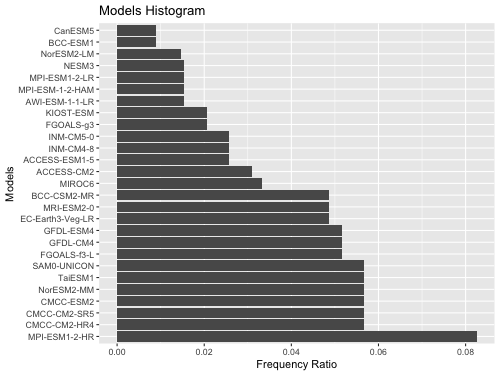

CPU times: user 4.85 s, sys: 4.46 s, total: 9.32 s
Wall time: 7.34 s


In [17]:
%%time
%%R -w 500 -h 375
df_r <- read_feather('../data/combined/combined_data.feather')

df_r %>%
  group_by(model) %>%
  summarise(n = n()) %>%
  mutate(Freq = n/sum(n)) %>%
  ggplot(aes(x = Freq, y = reorder(model, -n))) +
  geom_bar(stat = 'identity') +
  labs(x = "Frequency Ratio", y = "Models", title = "Models Histogram")

#### 6.3.2 Time compare (load feather and EDA)

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Arushi Ahuja| MacOS            | 8GB |Intel Core i5 |  Yes  | TO BE ADDED  |
| Dongxiao Li | MacOS | 8GB | Apple M1 | Yes |  TO BE ADDED  |
| Simon Guo   | MacOS | 16GB | Apple M1 | Yes |  TO BE ADDED  |
| Thomas Siu  | MacOS | 16GB | Apple M1 | Yes |  7.34s  |

#### 6.3.3 Baseline (csv) - shown as PNG only due to long loading time

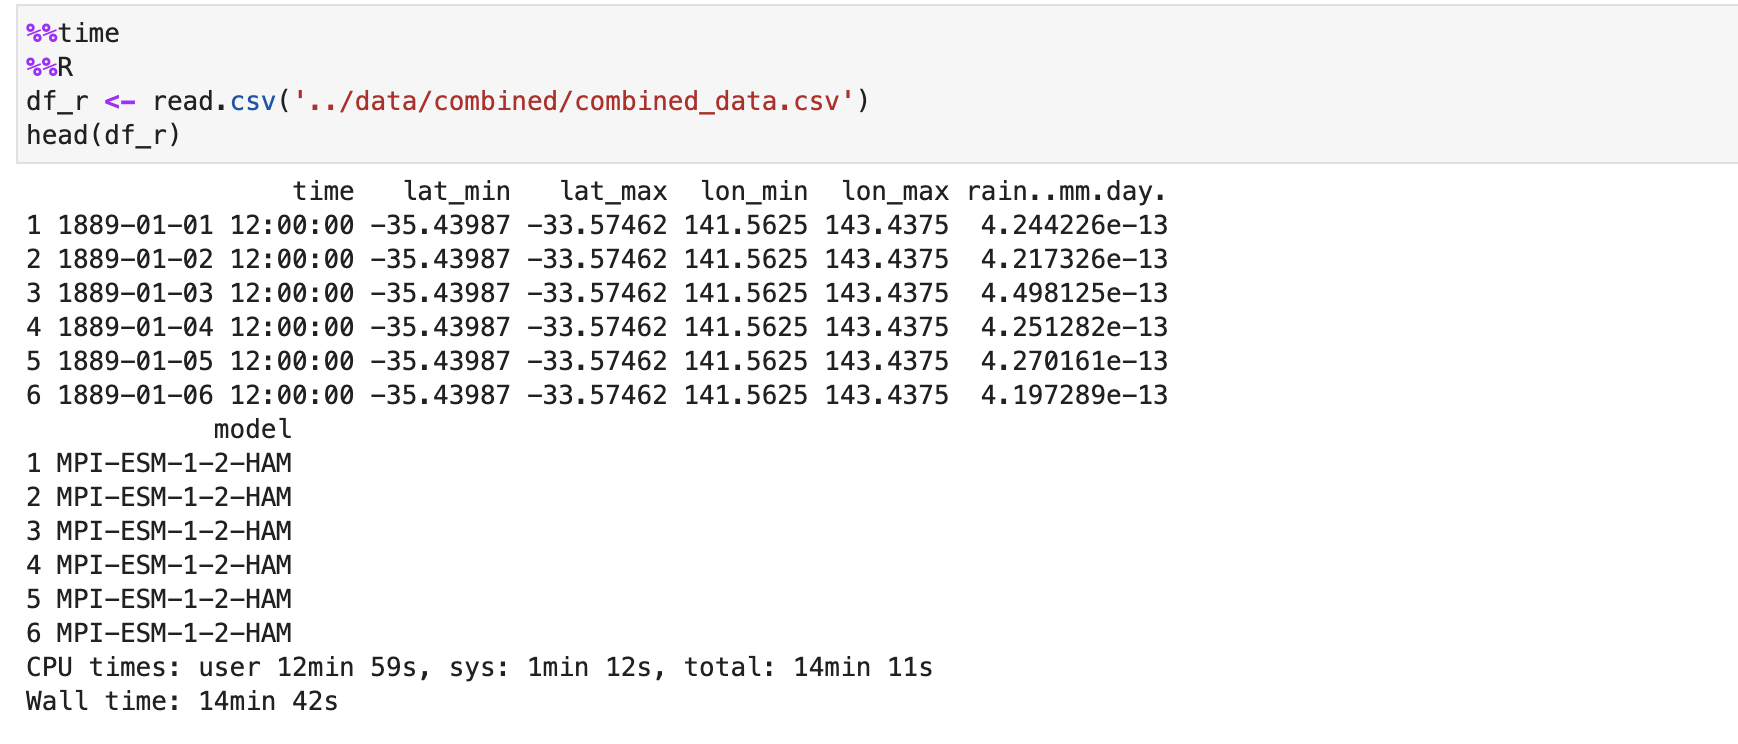

### 6.4 Discussions

We decided to transfer data frame to R from Python by saving the data frame into a 'feather' format and read it in R compared to other methods like pandas exchange, because we would like to save the time of loading the file into R. We can see that the time of loading the feather file we created to R is only around 9 seconds, compared to using csv which takes around 15 mins on Mac M1 which we only captured once as PNG due to long loading time.

Besides, by converting the combined csv to feather file, the file size is trimmed from around 6GB to less than 900 MB. It helps to save a lot of our storage space too.

### 7. Challenges and Difficulties

Discuss any challenges or difficulties you faced when dealing with this large amount of data on your laptops. Briefly explain your approach to overcome the challenges or reasons why you could not overcome them.